In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt


from utils import save_model, load_model

from functools import partial
import threading


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)

model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(8),
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(16),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(32),
    nn.Flatten(),
    nn.Linear(in_features=288, out_features=100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=64),    
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(in_features=64, out_features=10),
)

loss_fn = nn.CrossEntropyLoss()

In [3]:
def test(model, loss_fn, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=-1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    print('\nTest set: Average loss: {:.5f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [5]:
from core import Config, InputChannel, OutputChannel, train, Tuner

config = Config()

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=config.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=config.batch_size)

optimizer = optim.Adam(params=model.parameters(), lr=config.lr)

config = Config()

tuner = Tuner(optimizer, config)
tuner.show()

interactive(children=(BoundedFloatText(value=0.001, description='LR:', max=1.0), ToggleButton(value=False, but…

In [6]:
# training without multi threading
# train(input_channel=input_channel, output_channel=output_channel, model=model, device=device, dataloader=train_loader, optimizer=optimizer, epochs=100, trial_name="experiment_1")

thread = threading.Thread(target=lambda: tuner.train(model=model, loss_fn=loss_fn, device=device, dataloader=train_loader, optimizer=optimizer, epochs=100, trial_name="experiment_1"))
thread.daemon = True
thread.start()

Exception in thread Thread-4 (<lambda>):
Traceback (most recent call last):
  File "/home/shayan/miniconda3/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/home/shayan/miniconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "/home/shayan/miniconda3/lib/python3.11/threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_33021/2688832600.py", line 4, in <lambda>
NameError: name 'input_channel' is not defined. Did you mean: 'InputChannel'?


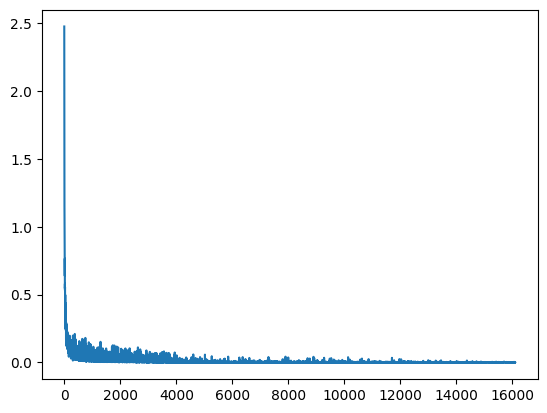

In [135]:
# can run while training
plt.plot(output_channel.losses)

In [139]:
from copy import deepcopy

model_copy = deepcopy(model)
test(model_copy, loss_fn=loss_fn, device=device, test_loader=test_loader)


Test set: Average loss: 0.02414, Accuracy: 9936/10000 (99.3600%)

